In [1]:
# SPFDM Assignment 1
# Luuk Oudshoorn and Willem-Jan de Voogd
# Fall 2020

In [194]:
import time
import numpy as np
import pandas as pd
import datetime as dt
from glob import glob
from scipy.interpolate import interp1d

# Import some of the basis required functions
from scipy.interpolate import Rbf, InterpolatedUnivariateSpline
from scipy import interpolate
from scipy.stats import norm
from joblib import Parallel, delayed
import networkx as nx
from scipy.stats import norm
import scipy as sp
import matplotlib.pyplot as plt
import ffn 
from matplotlib import collections as matcoll
%matplotlib inline

Text(0, 0.5, 'Rate (%)')

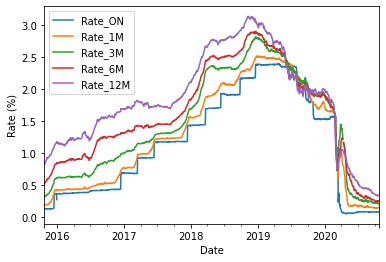

In [195]:
# Load LIBOR Rates
periods = ['ON','1M','3M','6M','12M']
LIBOR = pd.DataFrame()
for period in periods:
    filename = glob('./USD'+period+'*.csv')[0]
    LIBOR_sub = pd.read_csv(filename)
    LIBOR_sub['DATE'] = pd.to_datetime(LIBOR_sub['DATE'])
    LIBOR_sub.columns = ['Date','Rate_'+period]
    LIBOR_sub = LIBOR_sub.set_index('Date')
    LIBOR_sub = LIBOR_sub.replace('.',np.nan)
    LIBOR_sub['Rate_'+period] = LIBOR_sub['Rate_'+period].astype(float)
    LIBOR = pd.concat((LIBOR,LIBOR_sub),axis=1)
LIBOR.plot()
plt.ylabel('Rate (%)')

In [196]:
# Libor rates from ICE
# https://www.theice.com/marketdata/reports/170
#LIBOR = pd.DataFrame({'Name':['Rate_3M','Rate_6M','Rate_12M'],'Rate':[-0.52971,-0.52329,-0.47386]}).set_index('Name')
#LIBOR
# Latest libor rates
# These are annualized interest rates
LIBOR = pd.DataFrame({'Rate':LIBOR.iloc[-1,2:]})
LIBOR.loc['Rate_9M'] = interp1d([3,6,12],LIBOR.Rate,kind='linear')(9)
LIBOR['Nyear'] = [0.25,0.5,1,0.75]

In [197]:
# OIS curve, is 0.1% lower than Libor curve assuming fixed spread
# We bootstrap the OIS for quarterly payments
OIS = pd.DataFrame((LIBOR.Rate -0.1).sort_index())
OIS

,Rate
Rate_12M,0.236630
Rate_3M,0.116500
Rate_6M,0.149380
Rate_9M,0.193005


In [198]:
# OIS is the first part of the zero curve
zerocurve = pd.DataFrame({'Years':[1,0.25,0.5,0.75],'Zero rate':OIS.values.flatten()})

zerocurve = zerocurve.set_index('Years').sort_index()
zerocurve
for i in np.arange(1.25,30.1,0.25):
    zerocurve.loc[i] = np.nan
zerocurve

,Zero rate
Years,
0.25,0.116500
0.50,0.149380
0.75,0.193005
1.00,0.236630
1.25,NaN
...,...
29.00,NaN
29.25,NaN
29.50,NaN


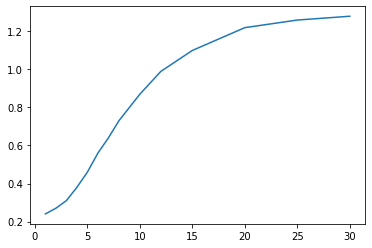

,Swap_Rate
Years,
1.00,0.2400
1.25,0.2475
1.50,0.2550
1.75,0.2625
2.00,0.2700
...,...
29.00,1.2760
29.25,1.2770
29.50,1.2780


In [234]:
# To obtain longer rates we need to bootstrap
# For bootstrapping we also need the swap rates. These are obtained from 
# http://www.interestrateswapstoday.com/swap-rates.html
def read_interp_swaprates():
    # Swap rates from web
    swaprates  =  pd.DataFrame({'Name':['1-Year','2-Year','3-Year', '4-Year','5-Year','6-Year','7-Year','8-Year','9-Year','10-Year','12-Year','15-Year','20-Year','25-Year','30-Year'],'Rate':[0.24,0.27,0.31,0.38,0.46,0.56,0.64,0.73,0.8,0.87,0.99,1.1,1.22,1.26,1.28]}).set_index('Name')
    swaprates['NMonths'] = [12,24,36,48,60,72,84,96,108,120,144,180,240,300,360]
    #We need to interpolate swaprates to get all intermediate values
    to_interpolate = np.arange(12,360.3,3)
    # We use cubic interpolation as this generates a much smoother curve
    interpolated = interp1d(swaprates['NMonths'],swaprates['Rate'],kind='linear')(to_interpolate)
    swaprates_interp = pd.DataFrame({'Years':to_interpolate/12,'Swap_Rate':interpolated})
    return swaprates_interp.set_index('Years')
swaprates_interp = read_interp_swaprates()
plt.plot(swaprates_interp.index, swaprates_interp.Swap_Rate)
plt.show()
swaprates_interp

In [207]:
# Having both libor and swap rates we should be able to bootstrap the zero curve

In [208]:
def bootstrap(disc_rates, disc_rates_times,to_calculate, swaprate, duration, payterm):
    """Takes known discounting rates and known swap rate for some times
       and returns the swaprate for an unknown time"""
    # payterm = years between payments
    # discount rates = libor/ois like rates
    # swaprate is the at-par rate for the IRS
    # duration is the number of years of the swap
    
    Npayments = duration / payterm - 1 # because we estimate one
    # We loop through all payments except for the unknown
    swapvalue = 0
    for i,time in enumerate(disc_rates_times):
        if time != duration: # intermediate payouts
            payout = swaprate * payterm
        elif time ==duration: #final payout
            payout = swaprate * payterm + 100
        depreciation = np.exp(-time*disc_rates[i]/100)
        swapvalue += payout * depreciation
    # The swap is now worth par, thus 100. We calculate the rate solving the 
    # missing term
    
    if to_calculate == duration:
        # If we miss the last term, then divide by 100+coupon
        rate = np.log((100-swapvalue)/(swaprate * payterm + 100))/(-to_calculate)
    elif to_calculate != duration:
        # If we search for an intermediate term, divide by coupon
        rate = np.log((100-swapvalue)/(swaprate * payterm))/(-to_calculate)
    return (rate*100)

In [209]:
# Example from Hull
disc_rates = [4,4.5,4.8]
disc_rates_times = [0.5,1,1.5]
to_calculate = 2
swaprate   = 5
duration   = 2
payterm    = 0.5
bootstrap(disc_rates, disc_rates_times,to_calculate, swaprate, duration, payterm)

4.952932701412535

In [210]:
# Inverse problem of Hull; we know 0.5,1,2
disc_rates = [4,4.5,4.95293270]
disc_rates_times = [0.5,1,2]
to_calculate = 1.5
swaprate   = 5
duration   = 2
payterm    = 0.5
bootstrap(disc_rates, disc_rates_times,to_calculate, swaprate, duration, payterm)

4.800000075157118

In [211]:
# We have swap rates for all 3 month periods by interpolation
# Using each swap rate we can now equate the zero yield rate for that period
for years,row in zerocurve.iterrows():
    if (np.isnan(row['Zero rate'])):
        # Unknown rate, bootstrap!
        # Obtain swap rate for this maturity
        swaprate = swaprates_interp.loc[years].Swap_Rate
        known_rates = zerocurve.loc[:years-0.25]
        zerorate = bootstrap(known_rates.values,known_rates.index,years,
                             swaprate,years,0.25)
        zerocurve.loc[years] = zerorate

In [212]:
zerocurve

,Zero rate
Years,
0.25,0.116500
0.50,0.149380
0.75,0.193005
1.00,0.236630
1.25,0.247490
...,...
29.00,1.305358
29.25,1.306331
29.50,1.307309


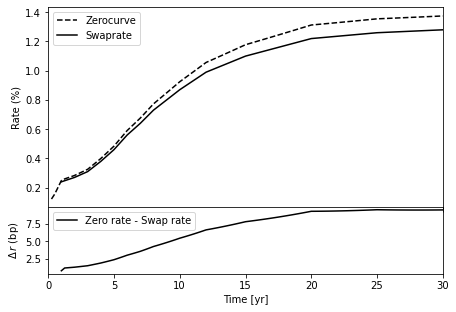

In [233]:
def plot_swap_zero():
    # Find difference between zerocurve and swaprate
    diff = pd.merge(zerocurve,swaprates_interp,left_index=True,right_index=True)
    diff['diff'] = diff['Zero rate'] - diff['Swap_Rate']

    fig, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]},figsize=(6,4),sharex=True)
    a0.plot(zerocurve.index, zerocurve.values,label='Zerocurve',color='black',ls='--')
    a0.plot(swaprates_interp.index, swaprates_interp.Swap_Rate,label='Swaprate',color='black')
    a1.plot(diff.index, 100*diff['diff'],color='black',label='Zero rate - Swap rate')
    a0.set_ylabel('Rate (%)')
    a1.set_ylabel(r'$\Delta\,r$ (bp)')
    a0.legend()
    a1.legend()
    a1.set_xlabel('Time [yr]')
    a0.set_xlim(0,30)
    a1.set_xlim(0,30)
    plt.tight_layout(pad=-0.5)
    plt.savefig('zerorates.pdf',bbox_inches='tight')
    plt.show()
plot_swap_zero()

In [215]:
# Now that we have the zerocurve, we can use it to valuate all kinds of IRS!


In [216]:
class swaps():
    def __init__(self,start, lifetime,dT=0.25,swaprate=None,lagged_libor=None, print_value = True):
        """Initialize function. For any swap we determine
           its value as difference between long and short
           position in bonds. If inception if now, we solve
           this value such that it is zero.
           For each swap we pay fixed and receive floating rate
           
           start = float number of years, e.g. -0.5
           lifetime = total lifetime since inception, e.g. 5
           swaprate = some rate in % if defined. To find swaprate, 
           it should be set to None
           lagged_libor = libor if swap already exists"""
        self.swapstart = start
        self.lifetime = lifetime
        self.swaprate=swaprate
        self.dT = dT
        if lagged_libor:
            self.floatlibor = lagged_libor
        else:
            self.floatlibor = LIBOR.set_index('Nyear').loc[dT].Rate
        if self.swaprate:
            # We need to calculate the present day value
            # of this swap, since it already exists and has
            # a defined swaprate
            self.irsvalue = self.valuate(self.swaprate,print_=print_value)
        else:
            # We need to find the swaprate such that the net
            # present value equals zero
            self.get_rate()
    
    def valuate(self,swaprate,print_=False):
        """We pay fixed and thus are short in fixed bond at 
           the swaprate r. We receive floating and are thus 
           long in floating bond."""
        # Fixed lag
        short = self.fixed_bond(swaprate)
        if print_:
            print('Fixed',short)
        # Floating lag
        long = self.floating_bond(self.floatlibor)
        if print_:
            print('Float',long) 
        return short - long
        
    def fixed_bond(self,rate):
        """Calculate value of fixed lag given rate"""
        time_remaining = self.lifetime + self.swapstart
        start     = [self.swapstart+w*self.dT for w in range(0,1000)]
        start     = np.sort(np.abs(start))[1]
        
        timesteps = np.arange(start,time_remaining,self.dT)
        
        # Each step in timesteps, we get discounted floating rate
        # Additionally, we receive final payment
        value = 0
        for timestep in timesteps:
            discount_rate = zerocurve.loc[timestep].iloc[0]
            discount_factor = np.exp(-timestep*discount_rate/100)
            discounted_cash = (rate*self.dT) * discount_factor
            value += discounted_cash
        # Final payment
        discount_rate = zerocurve.loc[time_remaining].iloc[0]
        discount_factor = np.exp(-time_remaining*discount_rate/100)
        value += (100+rate*self.dT)*discount_factor
        return value
    
    def floating_bond(self,libor, principal=100):
        """Floating bond is worth par after the first next payment
           and pays the LIBOR rate"""
        time_remaining = self.lifetime + self.swapstart
        start     = [self.swapstart+w*self.dT for w in range(0,1000)]
        start     = np.sort(np.abs(start))[1]
        discount_rate = zerocurve.loc[start].iloc[0]
        
        discount_factor = np.exp(-start*discount_rate/100)
        value = (principal+ principal*(libor/100) * self.dT) * discount_factor
        return value
    
    def valuate_call(self,x):
        """This function is called in order to optimize the swap rate such that th
           absolute value of the swap contract is zero"""
        return np.abs(self.valuate(x))
   
    def get_rate(self):
        """Find the rate r that makes the value of a swap equal 
           zero by minimizing the absolute value"""
        from scipy.optimize import minimize
        fit_res = minimize(self.valuate_call,x0=[1])
        self.fitrate = fit_res['x'][0]
        
    def amortized_client(self,rate):
        n_periods = self.lifetime / self.dT
        repay = 100/(n_periods)
        timesteps = np.arange(self.swapstart,self.lifetime,self.dT)
        interest = 0
        for i, timestep in enumerate(timesteps):
            discount_rate = zerocurve.loc[timestep+self.dT].iloc[0]
            discount_factor = np.exp(-(timestep)*discount_rate/100)
            interest += ((rate*self.dT) * (100 - i*repay))*discount_factor
        return interest, repay
        
    def value_amortized(self,rate,principal=100):
        n_periods = self.lifetime / self.dT
        repay = 100/(n_periods)
        timesteps = np.arange(self.swapstart+self.dT,self.lifetime+self.dT,self.dT)
        short = 0
        for i, timestep in enumerate(timesteps):
            discount_rate = zerocurve.loc[timestep].iloc[0]
            discount_factor = np.exp(-(timestep)*discount_rate/100)
            discounted_cash = ((rate*self.dT) * (100 - i*repay) + repay) * discount_factor
            short += discounted_cash
        long = self.floating_bond(self.floatlibor, principal)
        return short - long
    
    def valuate_amor(self,x):
        return np.abs(self.value_amortized(x))
    
    def get_amortized_rate(self):
        from scipy.optimize import minimize
        fit_rate = minimize(self.valuate_amor,x0=[1])
        return fit_rate['x'][0]*100

In [217]:
# Create back up of original zero-curve
zerocurve_base = zerocurve.copy()

In [218]:
# Find rate for swap
swapper = swaps(-0.25,10.25,0.25,None)
swapper.fitrate

0.8725790473095242

In [219]:
def paper_example():# Paper example
    zerocurve.loc[0.25] = 10
    zerocurve.loc[0.5] = 10.5
    zerocurve.loc[0.75] = 11
    zerocurve.loc[1] = 11.5
    # Find value of swap
    swapper = swaps(0,1,0.25,8)#-0.25,1.5,0.5,8)   
    return swapper.irsvalue   
paper_example()

Fixed 96.60929802037867
Float 97.58377985182179


-0.9744818314431143

In [220]:
amortized = swaps(0,5)
amortized.get_amortized_rate()

-0.08103762236786327

In [221]:
# find amortizing rate
zerocurve['Zero rate'] = zerocurve_base['Zero rate']
years = np.arange(1, 30.5, 0.5)
amor_rate = np.zeros(len(years))
payments = np.zeros(len(years))
interests = np.zeros(len(years))
for i, year in enumerate(years):
    amortized = swaps(0,year)
    value = amortized.get_amortized_rate()
    amor_rate[i] = value
    interest, repay = amortized.amortized_client(value)
    payments[i] = repay
    interests[i] = interest

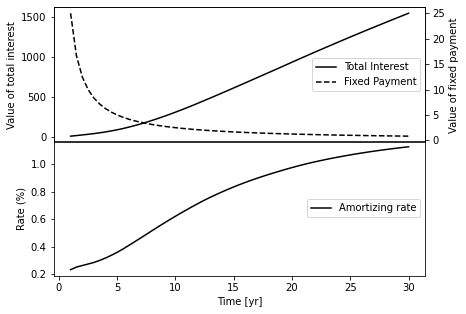

In [222]:
fig, (ax1,ax2) = plt.subplots(2,1,sharex=True)

ln1=ax1.plot(years, interests, label='Total Interest', color='black')
ax1.set_ylabel('Value of total interest')
ax1.legend()
ax3=ax1.twinx()
ln2=ax3.plot(years, payments, label='Fixed Payment',color='black',ls='--')
# added these three lines
lns = ln1+ln2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs,loc='center right')
ax3.set_ylabel('Value of fixed payment')
ax2.plot(years, amor_rate, color='black',label='Amortizing rate')
ax2.set_xlabel('Time [yr]')
ax2.set_ylabel('Rate (%)')
ax2.legend(loc='center right')
plt.tight_layout(pad=-1)
plt.savefig('amortizing.pdf',bbox_inches='tight')

In [223]:
# Example slides
def example_slides():
    zerocurve.loc[0.25] = 10
    zerocurve.loc[0.75] = 10.5
    zerocurve.loc[1.25] = 11

    swapper = swaps(-0.25,1.5,0.5,8,10.2)#-0.25,1.5,0.5,8)   
    return swapper.irsvalue  
example_slides()

Fixed 98.23789590103716
Float 102.50507175417775


-4.267175853140586

In [224]:
# Find rate for swap
swapper = swaps(0,10,0.5,None)
swap_rate = swapper.fitrate
def existing_swap():
    swapper = swaps(-0.25, 10, 0.5, swap_rate)
    return swapper.irsvalue
existing_swap() 

Fixed 100.335357800079
Float 97.65260259576408


2.6827552043149154

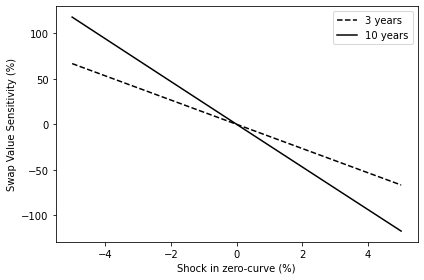

In [229]:
def sensitivity():
    # Already issued long-maturity swap - changes in sensitivity
    zerocurve['Zero rate'] = zerocurve_base
    # Calculate values for shocks in zerocurve
    shocks = np.arange(0.95, 1.05, 0.01)
    swap_value3 = np.zeros(len(shocks))
    swap_value10 = np.zeros(len(shocks))
    # Calculate swaprate for 3, 5 and 10 years
    swapper3 = swaps(0,3,0.5,None)
    swap_rate3 = swapper3.fitrate
    swapper10 = swaps(0,10,0.5,None)
    swap_rate10 = swapper10.fitrate
    # Calculate swapvalue with current zerocurve
    swapper3 = swaps(-0.25,3,0.5,swap_rate3, print_value=False) 
    zero_swap3 = swapper3.irsvalue
    swapper10 = swaps(-0.25,10,0.5,swap_rate10, print_value=False) 
    zero_swap10 = swapper10.irsvalue

    for i, shock in enumerate(shocks):
        zerocurve['Zero rate'] = zerocurve_base*shock
        swapper3 = swaps(-0.25,3,0.5,swap_rate3, print_value=False) 
        swapper10 = swaps(-0.25,10,0.5,swap_rate10, print_value=False)
        swap_value3[i] = swapper3.irsvalue
        swap_value10[i] = swapper10.irsvalue
    plt.plot((shocks-1)*100, ((swap_value3-zero_swap3)/zero_swap3)*100, label='3 years', color='black', ls='--')
    plt.plot((shocks-1)*100, ((swap_value10-zero_swap10)/zero_swap10)*100, label='10 years', color='black')
    plt.legend()
    plt.ylabel('Swap Value Sensitivity (%)')
    plt.xlabel('Shock in zero-curve (%)')
    plt.tight_layout()
    plt.savefig('sensitivity.pdf')
sensitivity()

<h2>Mean reversion</h2>

In [22]:
# We use mean reversion rather than geometric brownian motion

In [121]:
startingprice = 3500
strikeprice = 3300

In [122]:
class BinomialTree():
    def __init__(self,N, T, S, K,ret_arrays=True, ret_option=False, call_put = 'call', risk_premium = 0):
        """Initialize function with some hard coded variables"""
        self.N = N
        self.T = T
        self.S = S
        self.x0 = np.log(S)
        self.sigma = np.sqrt(12)*0.0428156
        self.rf = np.log((1+0.005/4)**4)
        self.K = K
        self.ret_arrays = ret_arrays
        self.ret_option = ret_option
        self.call_put = call_put
        halflife = 1/12
        self.eta = np.log(2)/halflife
        self.ltm = 3500 # long term mean
        self.xmean = np.log(self.ltm) #- self.sigma**2/(2*self.eta)
        self.binomial_tree()
        
    def prob_p(self,xt):
        """The probability for an upmove given the current position x_t. Depends on 
           mean value and mean reversion speed and sigma. Takes only xt."""
        dt = self.T/self.N
        return (0.5+0.5 * (self.eta*(-(xt-self.xmean))*np.sqrt(dt))/
                    (np.sqrt(self.eta**2 * (-(xt-self.xmean))**2 * dt + self.sigma**2)))

    def binomial_tree(self):
        """Uses mean reversion method"""
        # We simulate a model for x^* and only later add the expected values
        
        # Time steps given total duration and number of steps
        dt = self.T/self.N
        # Fill the tree with log prices
        log_pricetree = np.zeros([self.N+1,self.N+1])

        # Consider i up moves and j down moves
        for i in range(self.N+1):
            for j in range(self.N+1):
                if i+j <= self.N: 
                    x_ij = (self.xmean * (1-np.exp(-self.eta*(i+j)*dt)) + 
                            self.x0*np.exp(-self.eta*(i+j)*dt) +
                            (i-j)*self.sigma * np.sqrt(dt))
                    log_pricetree[j,i+j] = x_ij
        # Convert to log prices
        price_tree = np.exp(log_pricetree)
        self.price_tree = price_tree
        self.log_pricetree = log_pricetree
        # Get array with probabilities for up moves
        self.probup = np.zeros([self.N+1,self.N+1])
        for i in range(self.N+1):
            for j in range(self.N+1):
                if i+j <= self.N: 
                    self.probup[j,i+j] = self.prob_p(log_pricetree[j,i+j])



        # Derive the option value
        option = np.zeros([self.N+1, self.N+1])
        # Apply standard relations for price of put and call option
        if self.call_put == 'call':
            option[:,self.N] = np.max(np.vstack((np.zeros(self.N+1),price_tree[:,self.N]-self.K)),axis=0)
        elif self.call_put == 'put':
            option[:,self.N] = np.max(np.vstack((np.zeros(self.N+1),self.K-price_tree[:,self.N])),axis=0)

        # Consider i up moves and j down moves and work our way back through the tree
        for i in np.arange(self.N-1,-1,-1):
            for j in np.arange(self.N-1,-1,-1):
                if i+j < self.N: 
                    p_up = self.prob_p(log_pricetree[j,i+j])
                    discount = np.exp(-dt*self.rf)
                    #print(i,j,option[j,i+j+1],option[j+1,i+j+1],p_up)
                    option[j,i+j] = discount*(p_up*option[j,i+j+1] + (1-p_up)*option[j+1,i+j+1])

        self.price_tree = price_tree
        self.option_tree = option
        # Start value of the option is the first, depreciated, value of the option pricing tree
        self.option_value = option[0,0]

        if self.ret_arrays:
            return price_tree, option          
        if self.ret_option:
            return option[0,0]

    def plot_graph_2(self,data,data2, filename=''):
        """Plot the tree with the up-probabilities in it"""
        n = self.N
        fig, ax=plt.subplots(figsize=(7,5))
        G=nx.Graph()
        for i in range(0,n+1):
            for j in range(1,i+2):
                if i<n:
                    G.add_edge((i,j),(i+1,j))
                    G.add_edge((i,j),(i+1,j+1))

        posG={}

        for node in G.nodes:
            posG[node]=(node[0],n+2+node[0]-2*node[1])
        nx.draw(G,pos=posG, with_labels=False, ax=ax)

        dict_ = {}
        for node in G.nodes:
            dict_[node] = 0*' '+'S='+np.round(data[node[1]-1,node[0]],3).astype(str)+'\n'+'p='+np.round(data2[node[1]-1,node[0]],3).astype(str)
        labels=nx.draw_networkx_labels(G,pos=posG,labels=dict_, ax=ax,verticalalignment='bottom',
                                       horizontalalignment='right',bbox=dict(facecolor='w',alpha=.6))
        dict_ = {}
        for edge in G.edges:
            dict_[edge] = 'u' if edge[1][1]<=edge[0][1] else 'd'

        labels=nx.draw_networkx_edge_labels(G,pos=posG,edge_labels=dict_, ax=ax)


        plt.xlim(-(n+3)/10,n+0.2)
        plt.ylim(-0.4,6.4*n/3+0.5)
        plt.tight_layout()
        if filename is not '':
            plt.savefig(filename,dpi=500,bbox_inches='tight')
        return     
    def plot_graph(self,data, filename=''):
        """Plot the tree without the up-probabilities in it"""
        n = self.N
        fig, ax=plt.subplots(figsize=(7,5))
        G=nx.Graph()
        for i in range(0,n+1):
            for j in range(1,i+2):
                if i<n:
                    G.add_edge((i,j),(i+1,j))
                    G.add_edge((i,j),(i+1,j+1))

        posG={}

        for node in G.nodes:
            posG[node]=(node[0],n+2+node[0]-2*node[1])
        nx.draw(G,pos=posG, with_labels=False, ax=ax)

        dict_ = {}
        for node in G.nodes:
            dict_[node] = 0*' '+np.round(data[node[1]-1,node[0]],3).astype(str)
        labels=nx.draw_networkx_labels(G,pos=posG,labels=dict_, ax=ax,verticalalignment='bottom',
                                       horizontalalignment='right',bbox=dict(facecolor='w',alpha=.6))
        dict_ = {}
        for edge in G.edges:
            dict_[edge] = 'u' if edge[1][1]<=edge[0][1] else 'd'

        labels=nx.draw_networkx_edge_labels(G,pos=posG,edge_labels=dict_, ax=ax)


        plt.xlim(-(n+3)/10,n+0.2)
        plt.ylim(-0.4,6.4*n/3+0.5)
        plt.tight_layout()
        if filename is not '':
            plt.savefig(filename,dpi=500,bbox_inches='tight')
        return     

<>:116: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:151: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:116: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:151: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-122-645109b10a93>:116: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if filename is not '':
<ipython-input-122-645109b10a93>:151: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if filename is not '':


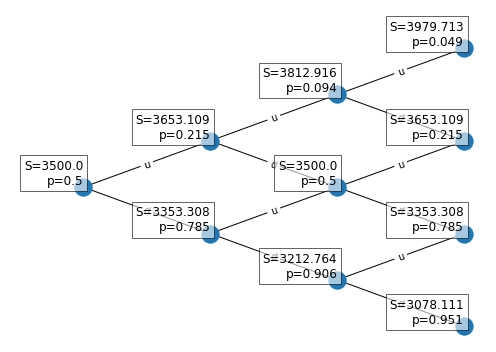

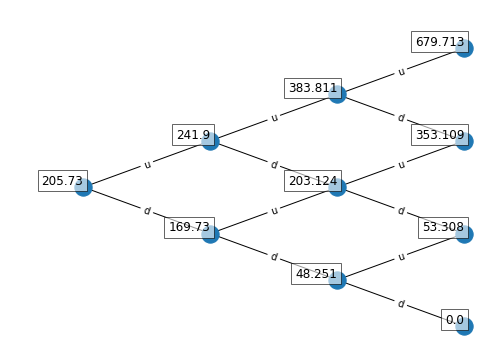

In [230]:
# run the binomial tree model
FirstBinomialTree = BinomialTree(3,3/12,startingprice,3300,call_put='call')
FirstBinomialTree.plot_graph_2(FirstBinomialTree.price_tree,FirstBinomialTree.probup, 'pricetree1.pdf')
FirstBinomialTree.plot_graph(FirstBinomialTree.option_tree,'option__valuetree.pdf')

In [124]:
from scipy.stats import norm
def black_scholes(S, K, T, r, sigma, call_put='call'):   
    """Return black scholes price of an option"""
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: interest rate
    #sigma: volatility of underlying asset
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))

    if call_put == 'call':
        optionprice = (S * norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * norm.cdf(d2, 0.0, 1.0))
    elif call_put == 'put':
        optionprice = (K * np.exp(-r * T) * norm.cdf(-d2, 0.0, 1.0) - S * norm.cdf(-d1, 0.0, 1.0))
    return optionprice

black_scholes(startingprice, 3300, 3/12, np.log((1+0.005/4)**4), np.sqrt(12)*0.0428156)

233.83981611202626

In [32]:
class MonteCarlo():
    def __init__(self,Npaths, Nsteps, T, S, K = 3300,eta = None, rf=None):
        """Function initialization like in the binomial tree model. 
           Predominantly fixed values"""
        # If we do not call the function with a value, 
        # initialize at the "standard" numbers
        if not rf:
            self.rf = np.log((1+0.005/4)**4)
        else:
            self.rf = rf
        self.sigma = np.sqrt(12)*0.0428156
        self.K     = K
        self.x0 = np.log(3500)
        halflife = 1/12
        if not eta:
            self.eta = np.log(2)/halflife
        else:
            self.eta = eta
        self.ltm = 3500 # long term mean
        self.xmean = np.log(self.ltm)# - self.sigma**2/(2*self.eta)
        self.dT = T/Nsteps
        self.Npaths = Npaths
        self.Nsteps = Nsteps
        self.var = self.sigma**2 / 2*self.eta
        self.T = T
        
    def propagate(self,xt):
        """Equate the monte carlo iteration as function of location xt"""
        N = 1 if type(xt)==np.float64 else len(xt)
        phi = np.random.randn(N)
        return (xt * np.exp(-self.eta*self.dT))+ self.xmean*(1-np.exp(-self.eta*self.dT)) + (self.sigma * np.sqrt(1-np.exp((-2*self.eta*self.dT)/(2*self.eta)))) * phi

    def simulate(self):
        """Iterate through the MCMC process for N steps and 1 path"""
        xt = np.zeros(self.Nsteps)
        # Initialize at start value
        xt[0] = self.x0
        for i in range(self.Nsteps-1):
            # propagate prices
            xt[i+1] = self.propagate(xt[i])
        prices = np.exp(xt)
        return prices
        
    def plot_single(self, filename=None):
        """Plot a single realization"""
        prices = self.simulate()
        timearr = np.arange(0,self.T,self.dT)
        plt.plot(timearr,prices,color='black',lw=0.5)
        # plot horitontal line at long term mean
        plt.axhline(self.ltm,ls='--',color='black',lw=1)
        plt.xlabel('Time [yr]')
        plt.ylabel('Stock price [USD]')
        plt.tight_layout()
        if filename:
            plt.savefig(filename)
        plt.show()
        
    def simulate_many(self):
        """Simulate Npaths for Nsteps"""
        xt = np.zeros((self.Npaths, self.Nsteps))
        # Same as before but now a whole matrix with N paths
        xt[:,0] = self.x0
        for i in range(self.Nsteps-1):
            xt[:,i+1] = self.propagate(xt[:,i])
        prices = np.exp(xt)
        return prices
        
    def plot_many(self):
        """Make a plot of the overall distribution and also plot the resulting PDF of final 
           prices."""
        prices = self.simulate_many()
        timearr = np.arange(0,self.T,self.dT)
        fig, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [4, 1]},figsize=(8,1.7))
        for i in range(self.Npaths-1):
            a0.plot(timearr,prices[i,:],color='black',lw=0.002)
        a0.plot(timearr,prices[i,:],color='green',lw=1.0)
        a0.axhline(self.ltm,ls='--',color='red',lw=1)
        a0.set_xlabel('Time [yr]')
        a0.set_ylabel('Stock price [USD]')
        a0.set_xticks(a0.get_xticks()[:-1])
        a0.set_xlim(-0.025,self.T)
        a0.set_ylim(2750,4250)
        
        a1.hist(prices[:,-1],bins=100, orientation="horizontal", color='gray')
        a1.set_xticks([])
        a1.set_yticks([])
        a1.set_ylim(2750,4250)
        a0.set_rasterized(True)
        fig.tight_layout(pad=-0.3)
        plt.savefig('manyMCtracks_PDF.png', dpi=400,bbox_inches='tight')
        plt.show()
        
    
    def option_price(self, optiontype='call'):
        """Equate option price by taking option value for each path, averaging and discounting back 
           to present day value using risk free rate. """
        # Get prices 
        prices = self.simulate_many()
        # Get final prices
        finalprices = prices[:,-1]
        # calculate option values
        if optiontype == 'call':
            optionvalues = np.max(np.vstack((np.zeros(len(finalprices)),finalprices-self.K)),axis=0)
        elif optiontype == 'put':
            optionvalues = np.max(np.vstack((np.zeros(len(finalprices)),self.K-finalprices)),axis=0)
        optionvalue = np.mean(optionvalues)
        # Discount to present value
        optionvalue = np.exp(-self.rf*self.T) * optionvalue
        return optionvalue

MC = MonteCarlo(400,50,18/12,3500)
#MC.plot_many()

In [28]:
# Investigate sensitivity to eta
from joblib import Parallel, delayed
def worker(eta):
    MC = MonteCarlo(5000000,20,18/12,3500,3300,eta)
    return MC.option_price()

def sensitivity_eta():
    halflifes = np.arange(1/12,15,1/12)
    etas = np.log(2)/halflifes
    prices = np.array(Parallel(n_jobs=22)(delayed(worker)(i) for i in etas))
    return halflifes,prices
halflifes,prices = sensitivity_eta()

In [232]:
def price_for_halflife():
    plt.plot(halflifes,prices, color='black',label='Monte Carlo option price')
    plt.xlabel('Half-life time [yr]')
    plt.ylabel('Option value [USD]')
    plt.axhline(black_scholes(startingprice, 3300, 18/12, np.log((1+0.005/4)**4), np.sqrt(12)*0.0428156),color='red',ls='--',label='BS limit')
    plt.tight_layout()
    plt.legend()
    plt.savefig('optionsensitivity_halflife.pdf')
price_for_halflife()

NameError: name 'halflifes' is not defined

In [33]:
# Investigate sensitivity to eta for two cases: low interest rate and high interest rate
def worker(T,rf):
    MC = MonteCarlo(25000,10,T,3500,3300, rf=rf)
    return MC.option_price()

def sensitivity_maturity(rf):
    maturity = np.arange(0,15,1/12)
    prices = np.array(Parallel(n_jobs=6)(delayed(worker)(i,rf) for i in maturity))
    return maturity,prices
maturity,prices = sensitivity_maturity(0.005)

<ipython-input-124-2093d347ab9f>:9: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
<ipython-input-124-2093d347ab9f>:10: RuntimeWarning: divide by zero encountered in double_scalars
  d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))


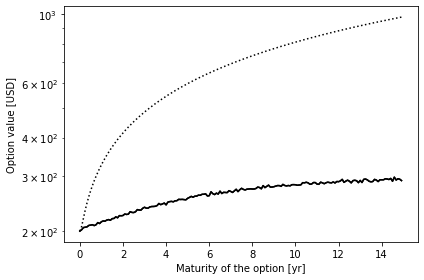

In [231]:
def price_for_maturity():
    fig, (ax1) = plt.subplots(1,1,sharex=True)
    ax1.plot(maturity,prices, color='black')
    ax1.set_ylabel('Option value [USD]')
    ax1.plot(maturity,prices, color='black')
    BSprices = [black_scholes(S=3500, K=3300, T=w, r=0.005, sigma=np.sqrt(12)*0.0428156) for w in maturity]
    ax1.plot(maturity,BSprices,label='Black-Scholes',color='black',ls='dotted')
    ax1.set_xlabel('Maturity of the option [yr]')
    plt.semilogy()
    plt.tight_layout()
    plt.savefig('optionsensitivity_maturity.pdf', bbox_inches='tight')
price_for_maturity()